## Frame Based Phoneme recognizer from pretrained models

+ ##### Authors: Bob Van Dyck, Dirk Van Compernolle
+ ##### History:  04/2022, 17/03/2023
+ ##### Requires: pyspch v0.7

Using frame based posteriors from DNNS

TODO:  GMMs are missing in comparison

### Functions

In [1]:
%matplotlib inline
import io, os, sys
import logging
import requests
import importlib
import urllib.request
import pickle
import gzip
import numpy as np
import pandas as pd
import scipy.io as sio
import torch
from scipy.fftpack import dct
# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# pyspch
import pyspch
import pyspch.nn

from IPython.display import display, HTML, Audio

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)
logging.basicConfig(level=logging.INFO)

# graphical and print preferences
cmap_car = sns.light_palette("caramel",50,input="xkcd")[0:25]
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]
#cmap="OrRd_r"

pd.options.display.float_format = '{:,.3f}'.format
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlepad'] = 14
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rc('lines', linewidth=2, color='k')

In [2]:
#@title Auxiliary functions 


# download from url and write to file
def write_from_url(url, filename):
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)

# dictionairy
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def dict_from_module(module):
    context = {}
    for setting in dir(module):
        # you can write your filter here
        if not setting.startswith('_'):
            context[setting] = getattr(module, setting)

    return context

# import setup file (.py) as module (dotdict)
def read_setup(filename, new_read_path=None, old_read_path='/users/spraak/spchlab/public_html/data/timit/'):
    
    # load module
    spec = importlib.util.spec_from_file_location(os.path.basename(filename), filename)
    setup = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(setup)
    
    # convert to dict 
    setup = dict_from_module(setup)
    setup = dotdict(setup)

    # replace esat_path with root_url
    if new_read_path is not None:
        for k, v in setup.items():
            if type(v) == str:
                setup[k] = v.replace(old_read_path, new_read_path)
            
    return setup


In [3]:
# some local system settings

# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"
    
# root url
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'

# paths
seg_url = root_url + 'segmentation/'    

### Feed Forward DNN Model

feature choices:
- mfcc13dd2mv:  MFCC39 with mean and variance normalization
- mel80mv:      MEL FBANK 80ch with mean and variance normalization
- mel24mv:      MEL FBANK 24ch with mean and variance normalization
frame combinations:
- N0s1:         center frame only
- N5s2:         center frame + 5 frames left and right with stride 2
                    i.e.  t-10, ... t-2, t , t+2, ... t+10

In [4]:
# model
# = mfcc13, delta_delta2, meanvar, 11 frames, stride 2
model_path = 'models/default/mfcc13dd2mv/N5s2/' 

# read checkpoint 
model_fobj = pyspch.read_fobj(root_url + model_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)

# unpack checkpoint (model, etc)
setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
# readout for one-hot encoding 
idx2lab = {v: k for k, v in lab2idx.items()}

setup = dotdict(setup)
model.to(device)

FFDNN(
  (net): Sequential(
    (0): Linear(in_features=429, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=768, bias=True)
    (4): Sigmoid()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=768, out_features=512, bias=True)
    (7): Sigmoid()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=41, bias=True)
  )
)

### Evaluate posteriors on utterance

In [5]:
# select file to visualize
example = 'test/dr1/faks0/si2203'
#example = 'test/dr8/fcmh1/si1493'

# audio
example_audio, sample_rate = pyspch.audio.load(root_url + 'audio/' + example + ".wav")

# transcription + word segmentation 
example_txt = pyspch.read_txt(root_url + 'segmentation/' + example + ".txt")
example_wrd = pyspch.timit.read_seg_file(root_url + 'segmentation/' + example + ".wrd", dt=1/sample_rate)
print(example_txt)

if example == 'test/dr1/faks0/si2203':    
    # segment selection "the reasons for this dive"
    phn_sel = np.array(['sil','cl','d','dh','r','z','s','f','n','m','ng','eh','ay','aa','ah','ih','iy'])
    frames=[57,134]
    
elif example == 'test/dr8/fcmh1/si1493':  
    # segment selection "by that time perhaps something "
    phn_sel = np.array(['sil','cl','b','dh','t','p','s','m','ay','aa','ae','ah','iy','th'])
    frames=[10,118]

['0 56218 The reasons for this dive seemed foolish now.']


In [6]:
# feature + modification + splicing
example_feature_1 = pyspch.sp.feature_extraction(example_audio, **setup.feature_args)
example_feature = pyspch.sp.splice_frames(example_feature_1, setup.sampler_args['N'], setup.sampler_args['stride']) # input

In [7]:
# labels , phone segmentation (+ as index)
example_phn = pyspch.timit.read_seg_file(root_url + 'segmentation/' + example + ".phn", fmt="float32", dt=1/sample_rate,xlat='timit61_timit41')
example_lab = pyspch.seg2lbls(example_phn, n_frames=example_feature.shape[1],pad_lbl='sil') 
example_labidx = [lab2idx[lbl] for lbl in example_lab] 

In [8]:
# input and target to tensor
example_X = torch.tensor(example_feature).T.float().to(device)
example_y = torch.tensor(example_labidx).long().to(device)

# posteriors 
example_yp = model(example_X) # log probs
example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs

# predicted labels (as numpy array) and as segmentation
example_yp_numpy = example_yp.cpu().detach().numpy()
example_yp_idx = np.argmax(example_yp_numpy, axis=1)
example_yp_lab = np.vectorize(idx2lab.get)(example_yp_idx)
example_yp_seg = pyspch.lbls2seg(example_yp_lab)

### Visualization

#### Spectrogram

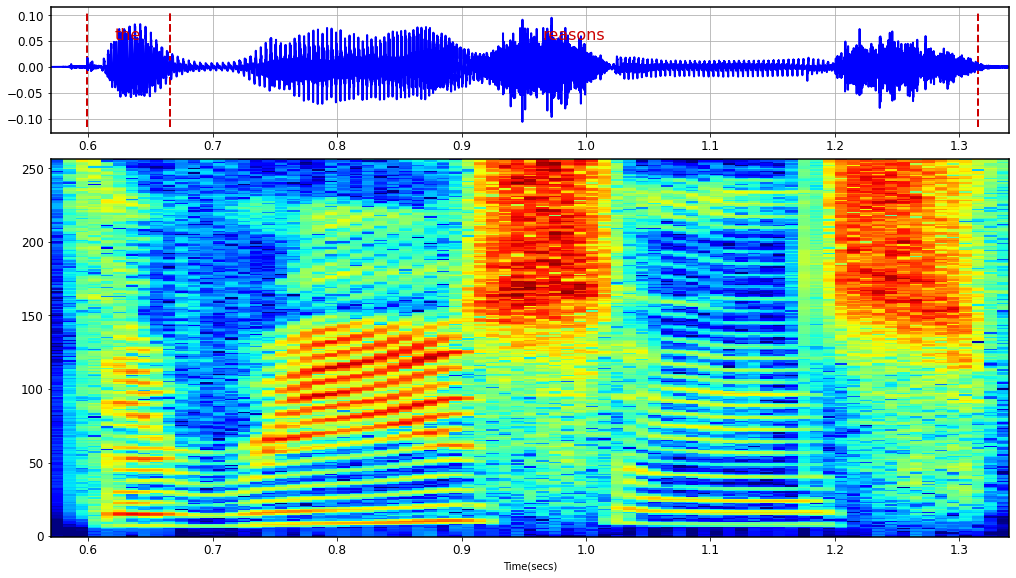

In [9]:
# compute a spectrogram with default parameters
example_spg = pyspch.sp.feature_extraction(example_audio, sample_rate=sample_rate) #, **setup.feature_args)
fig=pyspch.display.PlotSpg(wavdata=example_audio, spgdata=example_spg, segwav=example_wrd,dy=1,frames=frames,
                       sample_rate=sample_rate, figsize=(14,8))
display(fig)
display(Audio(data=example_audio,rate=sample_rate))

### Feature Extraction

The plots below shows different feature extractions, all based on Mel Frequency Cepstral Coefficients

+ Frame based mel frequency cepstral coefficients computed from the spectrogram  
   - mel frequency spectrogram (over 24 channels)  
   - cepstral conversion (truncation to 13 coefficients)  
   - mean and variance normalized on a sentence by sentence basis  
+ MFCC39:   
   - mel frequency 13 coefficients  
   - augmented by delta and delta-delta features  
   - mean and variance normalized on a sentence by sentence basis  
+ 11 frame stacked MFCC 39 features  
    - yielding a feature vector of dimension 429  
    - a stride of 2 is applied, thus the actual span of this feature vector is 21 frames  

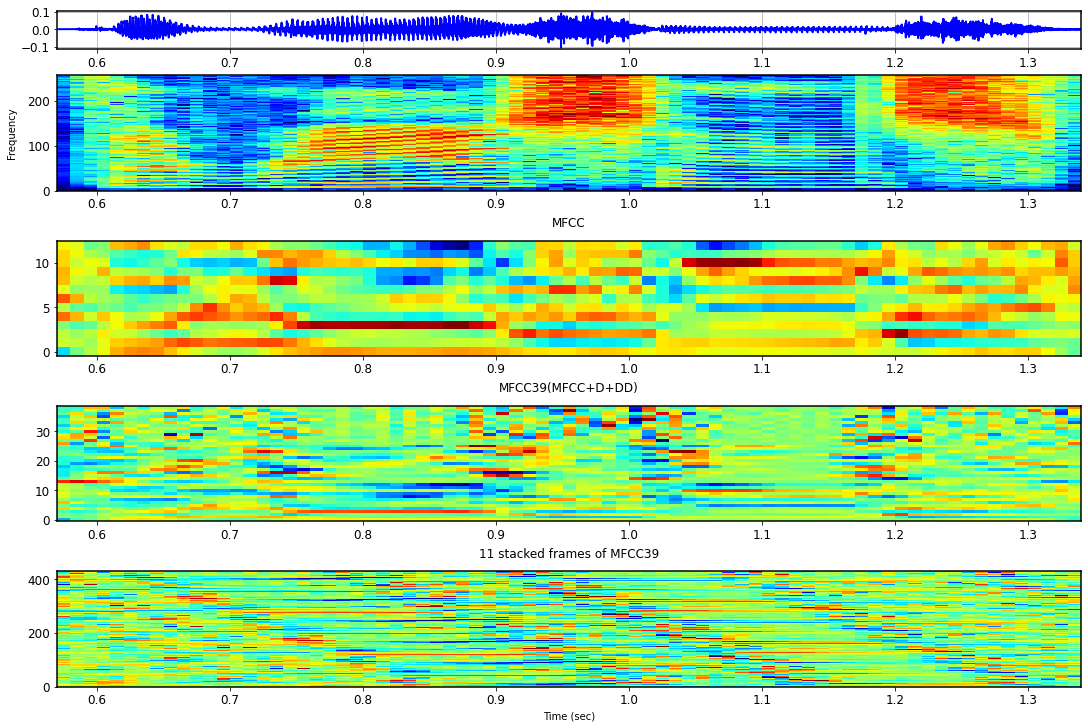

In [10]:
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_spg,
                                 frames=frames, sample_rate=sample_rate,
                                 figsize=(15,10), 
                                 img_ftrs=[example_feature_1[0:13,:],example_feature_1,example_feature])
fig.axes[2].set_title('MFCC')
fig.axes[3].set_title('MFCC39(MFCC+D+DD)')
fig.axes[4].set_title('11 stacked frames of MFCC39')
display(fig)

### Features, posteriors and predicted labels

In [11]:
def plot_probs(probs, labels, fig, iax=2, x0=0., title="", style="line"):
    ax = fig.axes[iax]
    ## !! only works properly for starting frame = 0
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,linewidths=1,linecolor='k')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T, iax=iax, x0=x0, dx=.01, yrange=[0.,1.])
        fig.axes[iax].legend(labels, loc='center right')  # , ncol=15)
    ax.set_title(title)

In [12]:
# select frames and labels to plot
frame_sel = slice(frames[0],frames[1])
indx_sel = [lab2idx[phn] for phn in phn_sel]

# posteriors and labels
prob_dnn_sel = example_yp_numpy[frame_sel, indx_sel]
# prob_gmm_sel = TODO 

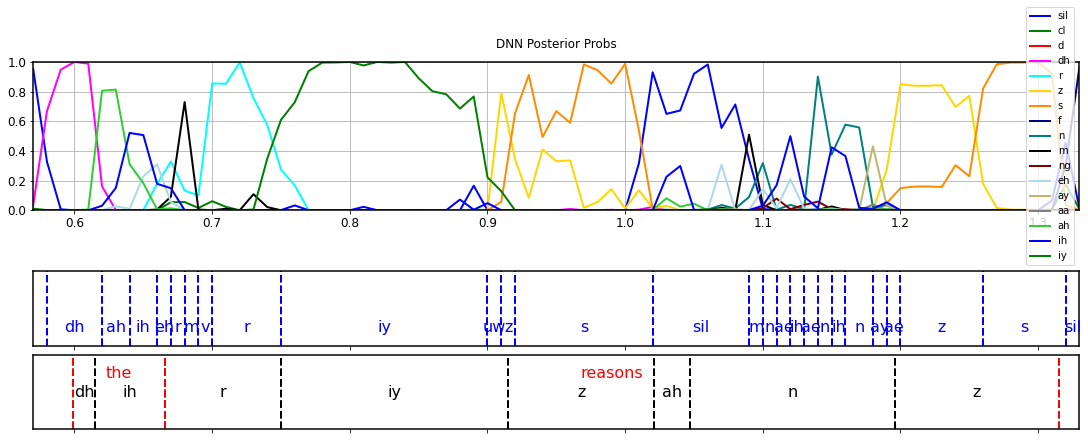

In [13]:
# figure 
# !GMM probs missing (hence, empty panel)
fig = pyspch.display.SpchFig(row_heights=[2,1,1], figsize=(15,6)) # init
plot_probs(prob_dnn_sel, phn_sel,fig=fig, iax=0, x0=frames[0]*.01, style="line", title="DNN Posterior Probs") # probs
# plot_probs(prob_gmm_sel, phn_sel, iax=0, x0=frames[0]*.01, style="line", title="GMM Posterior Probs")
fig.add_seg_plot(example_phn, iax=2, ypos=.5, color='k') # seg
fig.add_seg_plot(example_wrd, iax=2, ypos=.75, Lines=True, color='r')
fig.add_seg_plot(example_yp_seg, iax=1, ypos=.25, Lines=True, color='b') # predicted labels
fig

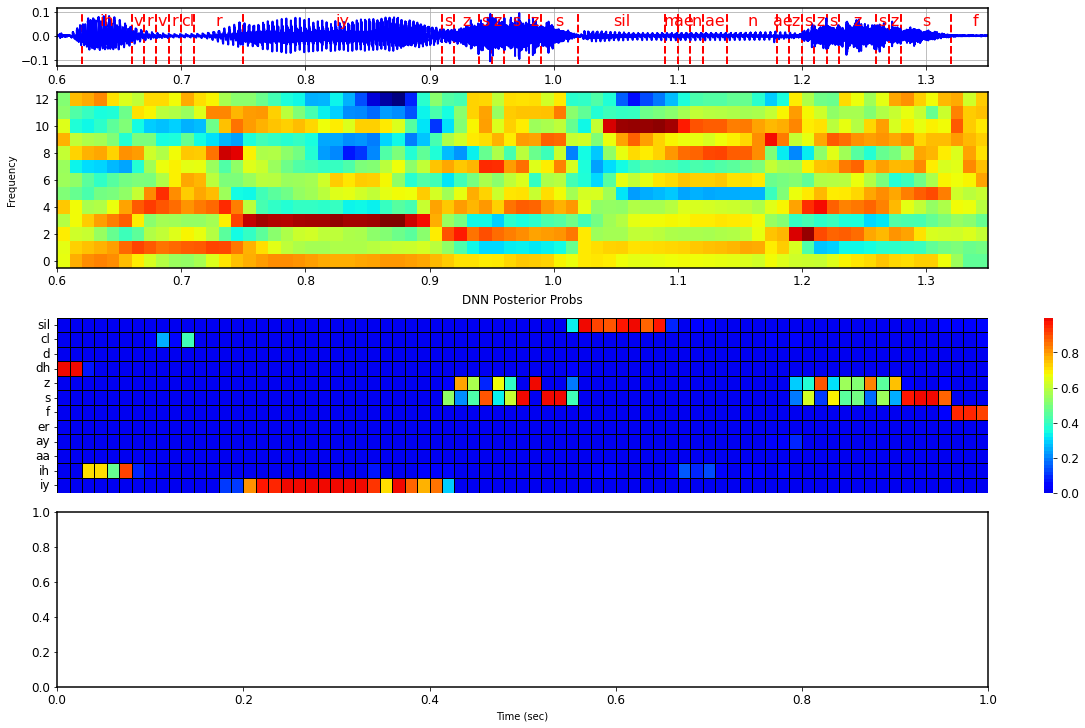

In [57]:
# figure 
# !GMM probs missing (hence, empty panel)
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_feature_1[0:13,:],dy=1,
                                 frames=frames, sample_rate=sample_rate,
                                 figsize=(15,10), img_ftrs=[None,None])
plot_probs(prob_dnn_sel, phn_sel, fig=fig, iax=2, style="img", title="DNN Posterior Probs")
#plot_probs(prob_gmm_sel,fig=fig,iax=3,style="img",title="GMM Posterior Probs")
fig.add_seg_plot(example_yp_seg, iax=0, ypos=0.8)
fig